In [1]:
!pip3 install pytesseract
!sudo apt install tesseract-ocr

import cv2
import imutils
from imutils import contours as cont
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pytesseract
from PIL import Image
from pytesseract import image_to_string
from tensorflow import keras
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import tensorflow as tf
from google.colab import drive
from PIL import Image, ImageOps
from PIL import Image, ImageEnhance 
import pandas as pd

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

drive.mount('/content/gdrive')

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=1ea9d53c37fe0b4412dc514c7e407ca3fc1d9397f79edb8b4875e24f8fb798da
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [16]:
model_save_name = 'digits.model'
path = F"/content/gdrive/My Drive/UC/S2/INFO601/{model_save_name}" 
model = keras.models.load_model(path)

model_save_name5 = 'model_hand1.h5'
path5 = F"/content/gdrive/My Drive/UC/S2/INFO601/{model_save_name5}" 
model5 = keras.models.load_model(path5)

In [3]:
print('# LOADING STUDENT INFO FROM DATA BASE')
path = F"/content/gdrive/My Drive/UC/S2/INFO601/NameID.xlsx"
df_raw = pd.read_excel(path, dtype=str)
df = df_raw

print(df.head(34))

# LOADING STUDENT INFO FROM DATA BASE
    firstname  lastname        ID
0       holly   jessica  17245221
1       paige    olivia  33728119
2        ruby    hannah  67124451
3       ebony    joshua  73124592
4      harris      jack  34512579
5       sarah    samuel  72315427
6        ryan     james  02845671
7       laura  matthews  42378911
8        jade    sophie  14253210
9       david  williams  72036521
10     tamara   o'brien  56701245
11      sarah    peters  87234215
12      felix    bishop  32105627
13      emily     dixon  50243247
14       eric   douglas  45613289
15      oscar     payne  87413562
16     stacey    abrams  30258942
17    timothy     burke  24768913
18      elias    sutton  04278950
19    kaitlyn    malone  80342146
20     justin      wang  43205098
21   campbell   johnson  15234250
22    matthew      king  87142389
23   anderson    cooper  34457156
24   browning    wilson  23142587
25      gemma  cheyenne  94540561
26       niam       fox  97214358
27  johnst

In [4]:
######################################
########## DIGIT OCR MODEL ###########
######################################

def predict_digit(output1,w1,w2,h1,h2):
  im = output1
  height = im.shape[0]
  width = im.shape[1]
  ratio = int(width/height *200)
  im = cv2.resize(im,(ratio,200))


  # RGB to grayscale conversion
  im_gray = im
  # grayscale to binary
  _, im_bw = cv2.threshold(im_gray, 100, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

  # invert image
  im_bw = 255-im_bw

  # find contours
  cnts, hierarchy = cv2.findContours(im_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

  # remove small components based on area
  if cnts is not None:
      for i in range(0, len(cnts)):
          a = cv2.contourArea(cnts[i])
          if a < 10:
              cv2.drawContours(im_bw, cnts, i, 0, cv2.FILLED)

  im_bw = 255-im_bw

  im_bw = cv2.GaussianBlur(im_bw , (5, 5), 0)

  cv2.imwrite('im_bw.jpg',im_bw)
  output= cv2.imread('im_bw.jpg')

  image = cv2.imread('im_bw.jpg')
  print("[INFO] loading handwriting OCR model...")
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred =cv2.bilateralFilter(gray,9,75,75)

  # perform edge detection, find contours in the edge map, and sort the
  # resulting contours from left-to-right
  edged = cv2.Canny(blurred, 50, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]

  # initialize the list of contour bounding boxes and associated
  # characters that we'll be OCR'ing
  chars = []

  # loop over the contours
  for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if ((w >= 3 and w <= 30  and h >= 50 +h1 and h <= 200 and y < 130 and y+h >=100) or
       (w > 30 and w <= 200  and h >= 50 + h2 and h <= 200 and y < 150 and y+h >=100)):
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
      roi = gray[y:y + h, x:x + w]
      thresh = cv2.threshold(roi, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      (tH, tW) = thresh.shape

      # if the width is greater than the height, resize along the
      # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=28)

      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=28)

      # re-grab the image dimensions (now that its been resized)
      # and then determine how much we need to pad the width and
      # height such that our image will be 28*28
      (tH, tW) = thresh.shape
      dX = int(max(0, 28 - tW) / 2.0)
      dY = int(max(0, 28 - tH) / 2.0)

      # pad the image and force 32x32 dimensions
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
      padded = cv2.resize(padded, (28, 28))

      # prepare the padded image for classification via our
      # handwriting OCR model
      padded = padded.astype("float32") / 255.0
      padded = np.expand_dims(padded, axis=-1)

      # update our list of characters that will be OCR'd
      chars.append((padded, (x, y, w, h)))

  # extract the bounding box locations and padded characters
  boxes = [b[1] for b in chars]
  chars = np.array([c[0] for c in chars], dtype="float32")

  # OCR the characters using our handwriting recognition model
  preds = model.predict(chars)

  # define the list of label names
  labelNames = "0123456789"
  labelNames = [l for l in labelNames]
  string = ''
  # loop over the predictions and bounding box locations together
  for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    if prob > 0.7:
      label = labelNames[i]
      # draw the prediction on the image
      print("[INFO] {} - {:.2f}%".format(label, prob * 100))
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(image, label, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
      string += str(labelNames[i]) 
      #cv2_imshow(image)
  cv2_imshow(image)
  print('Outcome :' + string)
  return string



######################################
######### LETTER OCR MODEL ###########
######################################

word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',
             6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',
             12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',
             18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

def predict_letter(output1):

  im = output1
  height = im.shape[0]
  width = im.shape[1]
  ratio = int(width/height *200)
  im = cv2.resize(im,(ratio,200))

  # RGB to grayscale conversion
  im_gray = im

  # grayscale to binary
  _, im_bw = cv2.threshold(im_gray, 150, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

  # invert image
  im_bw = 255-im_bw

  # find contours
  cnts, hierarchy = cv2.findContours(im_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

  # remove small components based on area
  if cnts is not None:
      for i in range(0, len(cnts)):
          a = cv2.contourArea(cnts[i])
          if a < 10:
              cv2.drawContours(im_bw, cnts, i, 0, cv2.FILLED)

  im_bw = 255-im_bw
  im_bw = cv2.GaussianBlur(im_bw , (5, 5), 0)
  cv2.imwrite('im_bw.jpg',im_bw)
  output= cv2.imread('im_bw.jpg')

  image = cv2.imread('im_bw.jpg')
  # load the handwriting OCR model
  print("[INFO] loading handwriting OCR model...")
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred =cv2.bilateralFilter(gray,9,35,35)

  # perform edge detection, find contours in the edge map, and sort the
  # resulting contours from left-to-right
  edged = cv2.Canny(blurred, 50, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]

  # initialize the list of contour bounding boxes and associated
  # characters that we'll be OCR'ing
  chars = []
  string = ''
  # loop over the contours
  for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if h > 30 and w > 5 and w < 400:
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
      roi = gray[y:y + h, x:x + w]

      img = cv2.resize(roi, (400,440))
      
      repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
      img = 255 - cv2.morphologyEx(255 - img, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

      img_copy = cv2.GaussianBlur(img, (3,33), 0)
      img_gray = img_copy
      _, img_thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY_INV)

      img_final = cv2.resize(img_thresh, (28,28))
      img_final =np.reshape(img_final, (1,28,28,1))


      img_pred = word_dict[np.argmax(model5.predict(img_final))]

      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(image ,img_pred, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    
      string = str(img_pred)
      cv2_imshow(image)
      print('Outcome :' + string)
      break
  return string

#######################################
###### TOTAL OF QUESTION MARKS ########
#######################################
def QM(v1,v2,v3,v4,v5,v6,v7,v8):
  Pred_TQM = 0
  for c in my_list:
    x,y,w,h = cv2.boundingRect(c)
    a = result[y - 3 :y + h, x: x + w]
    b = pytesseract.image_to_string(a,config='--psm 6')
    b = b.lower()
    if (("q1" in b) or ("ql" in b) or ("qi" in b) or
        ("q2" in b) or ("q3" in b) or ("q4" in b) or
        ("q5" in b) or ("qs" in b) or ("q6" in b) or
        ("q7" in b) or ("q8" in b) or ("q9" in b)):
      print(b)
      Mark = result[y + v1:y + h + v2, x + w + v3: x + w + v4]
      cv2_imshow(Mark)
      try:
        PQM = predict_digit(Mark,v5,v6,v7,v8)
      except ValueError:
        PQM = 0
      Pred_TQM = Pred_TQM + int(PQM)
  return Pred_TQM

#######################################
############# MATCHING ################
#######################################

def matching(ID,F,L):
  m = 0
  for index, row in df.iterrows():
    r = 0
    token = str(df.ID[index])


    d = abs(len(ID) - len(token))

    if len(token) > len(ID):
      for i in range(0,d+1):
        for j in range(0,len(ID)):
          if ID[j] == token[j+i]:
            r = r + 1
    else:
      if len(token) < len(ID):
        for i in range(0,d+1):
          for j in range(0,len(token)):
            if ID[j+i] == token[j]:
              r = r + 1
      else:
        for j in range(0,len(ID)):
          if ID[j] == token[j]:
            r = r + 1

    if F == df.firstname[index][0]:
      r = r +1

    if L == df.lastname[index][0]:
      r = r + 1
    
    if r > m:
      m = r
      ind = index

      
  print("\n===============================================================")
  #print(m)
  #print(ind)
  print("\nID :" ,str(df.ID[ind]))
  print("\nFirstName: " ,str(df.firstname[ind]))
  print("\nLastName: " ,str(df.lastname[ind]))
  print("\n===============================================================\n")

  

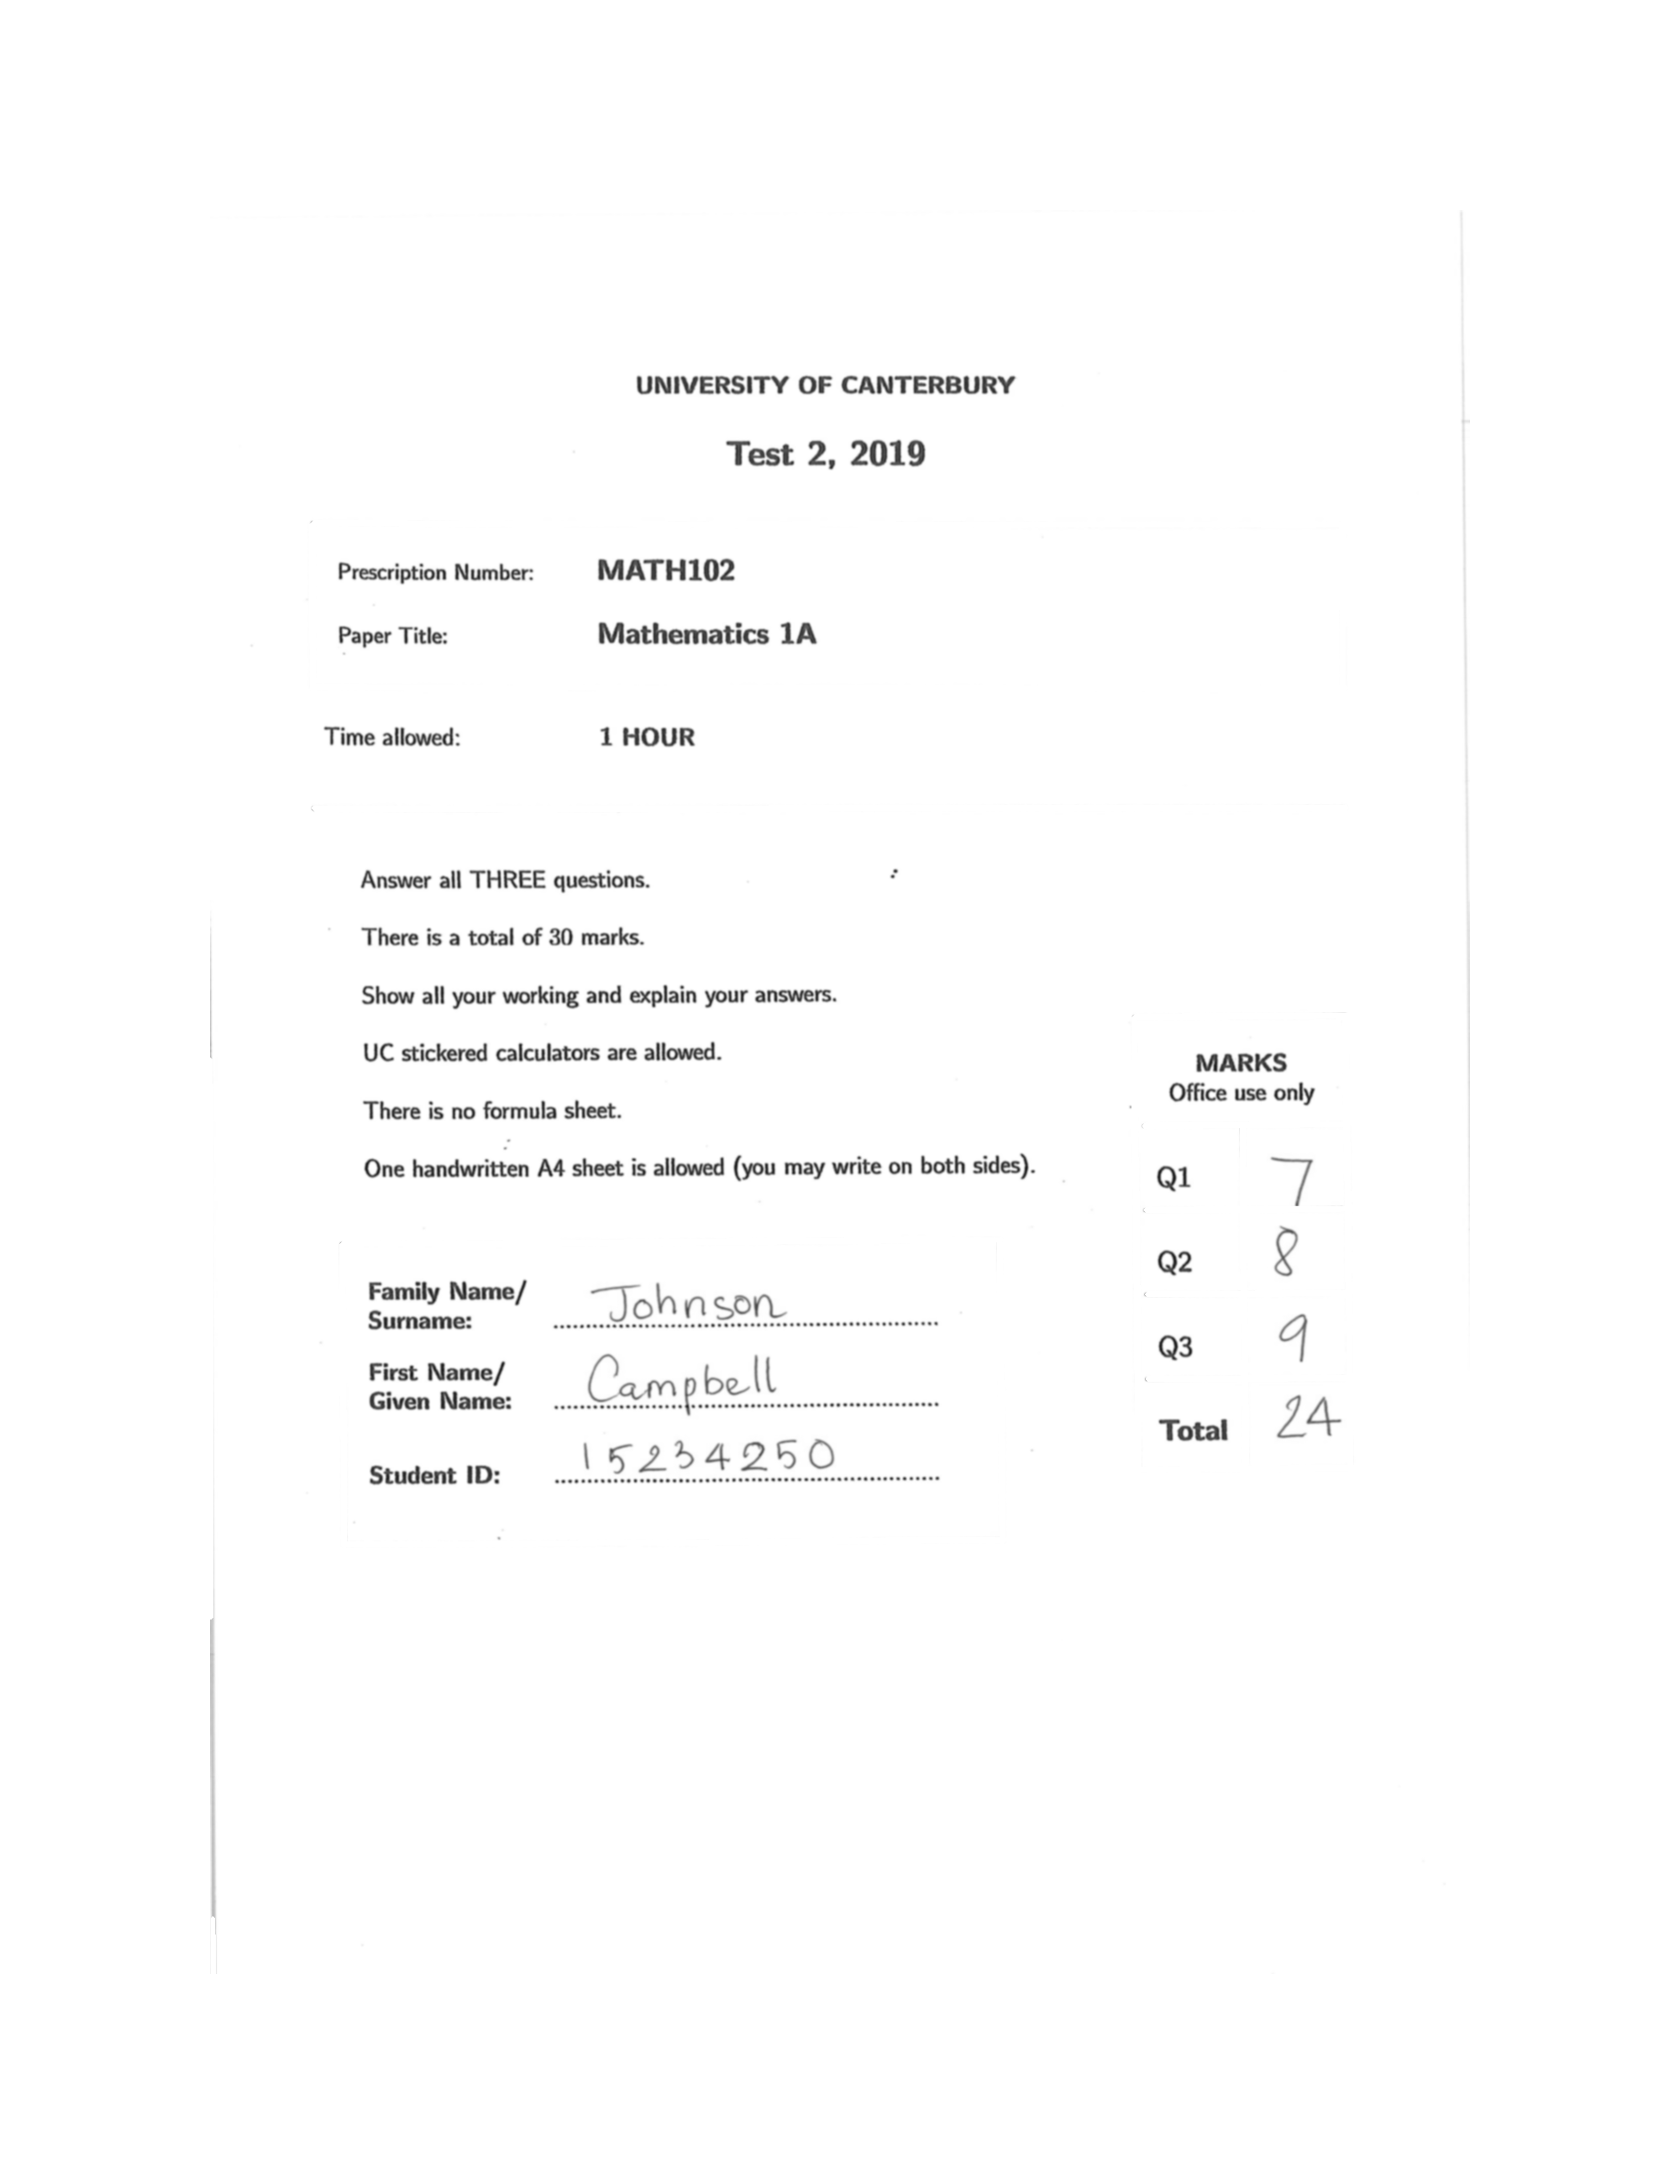

In [8]:
image = cv2.imread(F"/content/gdrive/My Drive/UC/S2/INFO601/testdata/20210131103346563_0007.jpg")
image = cv2.resize(image,(1500,2100))
result = image.copy()
blur = cv2.GaussianBlur(image, (5,5), 0)
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(gray, [c], -1, (255,255,255), 3)

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(gray, [c], -1, (255,255,255), 3)

# border widths; I set them all to 250
color = [255, 255, 255]
top, bottom, left, right = [250]*4
result = cv2.copyMakeBorder(gray, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
#_, result = cv2.threshold(result, 50, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

# invert image
#result = 255-result
cv2_imshow(result)

#cv2.imwrite('result.png', result)
#cv2.waitKey()

id:



student



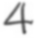

4



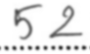

bl



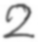

2



4



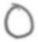

oo



5



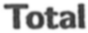

total



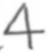

a



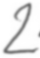

.



given



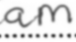

p



first



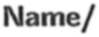

name/



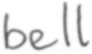

bell



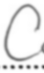

c



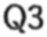

q3



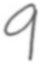

q



surname:



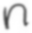

n



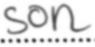

sore



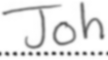

“joh



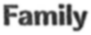

family



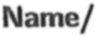

name/



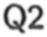

q2



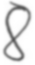

q



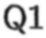

ql



on



may



write



a4



handwritten



one



sheet



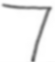

|



allowed



both



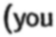

(you



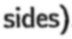

sides)



no



formula



there



sheet



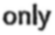

only



office



marks



are



calculators



stickered



uc



allowed.



your



your



answers.



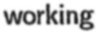

working



show



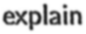

explain



and



30



total



is



marks.



of



there



questions.



three



answer



hour



allowed



time



title:



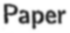

paper



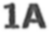

1a



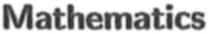

mathematics



number:



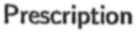

prescription



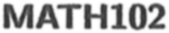

math102



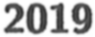

2019



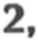

2,



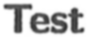

test



canterbury



of



university



In [9]:
  im = result
  #wi = int(im.shape[1])
  hi = int(im.shape[0])

  # RGB to grayscale conversion
  #im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im_gray = im
  # grayscale to binary
  _, im_bw = cv2.threshold(im_gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

  # invert image
  im_bw = 255-im_bw

  # find contours
  cnts, hierarchy = cv2.findContours(im_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

  # remove small components based on area
  if cnts is not None:
      for i in range(0, len(cnts)):
          a = cv2.contourArea(cnts[i])
          if a < 10:
              cv2.drawContours(im_bw, cnts, i, 0, cv2.FILLED)

  im_bw = 255-im_bw
  cv2.imwrite('im_bw.jpg',im_bw)
  output= cv2.imread('im_bw.jpg')
# Load image, grayscale, Gaussian blur, adaptive threshold
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    area = cv2.contourArea(c)
    if area > 500 and area < 6000:
        x,y,w,h = cv2.boundingRect(c)
        #cv2.rectangle(result, (x, y), (x + w, y + h), (255,0,255),2)
        a = result[y:y + h, x: x + w]
        #repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        #a = 255 - cv2.morphologyEx(255 - a, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
        b = pytesseract.image_to_string(a,config='--psm 6').lower()
        cv2_imshow(a)
        print(b)
        

               
       

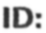

id:



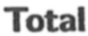

total



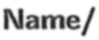

name/



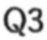

q3



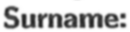

surname:



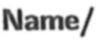

name/



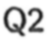

q2



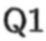

ql



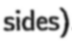

sides)



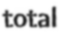

total



number:



In [10]:
my_list = []
for c in cnts:
  x,y,w,h = cv2.boundingRect(c)
  a = result[y-3:y + h, x: x + w]
  b = pytesseract.image_to_string(a,config='--psm 6').lower()
  if (("q1" in b) or ("ql" in b) or ("qi" in b) or 
            ("q2" in b) or ("q3" in b) or ("q4" in b) or 
            ("q5" in b) or ("qs" in b) or ("q6" in b) or 
            ("q7" in b) or ("q8" in b) or ("q9" in b) or
            ("name" in b) or ("total" in b) or ("id" in b) or 
            ("number" in b) or ("venue" in b)): 
    my_list.append(c)
    cv2_imshow(a)
    print(b)


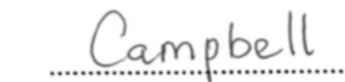

II




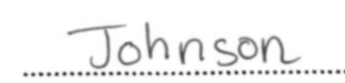

VI

TYPE: 
2


In [11]:

sub = 0
for c in my_list:
  x,y,w,h = cv2.boundingRect(c)
  a = result[y - 3 :y + h, x: x + w]
  b = pytesseract.image_to_string(a,config='--psm 6')
  b = b.lower()
  if "venue" in b: 
    sub = 1

for c in my_list:
  x,y,w,h = cv2.boundingRect(c)
  a = result[y -3 :y + h, x: x + w]
  b = pytesseract.image_to_string(a,config='--psm 6')
  b = b.lower()
  if "name" in b: 
    if "first" in pytesseract.image_to_string(result[y - 5 :y + h, x - 200: x + w],config='--psm 6').lower():
      if "given" in pytesseract.image_to_string(result[y - 5 :y + h, x - 200: x + w],config='--psm 6').lower():
        FirstName = result[y - 15 :y + h + 15, x + w + 100 : x + w + 450]
        cv2_imshow(FirstName)
        print("I")

      else:
        if "given" in pytesseract.image_to_string(result[y - 5 :y + h+30, x - 200: x + w],config='--psm 6').lower():
          print("\n")
          FirstName = result[y - 15 :y + h+30, x + w + 5: x + w +350]
          cv2_imshow(FirstName)
          print("II")
        
        else:
          print("\n")
          FirstName = result[y - 25 :y + h + 10 , x + w : x + w + 450]
          cv2_imshow(FirstName)
          print("III")
    
    else:
      if "given" in pytesseract.image_to_string(result[y - 15 :y + h, x - 150: x + w],config='--psm 6').lower():
        if "first" not in pytesseract.image_to_string(result[y - 40 :y + h, x - 100: x + w],config='--psm 6').lower():
          print("\n")
          FirstName = result[y - 35 :y + h +15 , x+w: x + w + 400]
          cv2_imshow(FirstName)
          print("IV")      


      else:
        if "family" in pytesseract.image_to_string(result[y - 5 :y + h, x - 200: x + w],config='--psm 6').lower():
          if "sur" in pytesseract.image_to_string(result[y - 5 :y + h, x - 200: x + w],config='--psm 6').lower():
            print("\n")
            SurName = result[y - 15 :y + h + 15, x + w + 100 : x + w + 450]
            cv2_imshow(SurName)
            t = 1
            print("V")
          
          else:
            if "sur" in pytesseract.image_to_string(result[y - 5 :y + h+40, x - 150: x + w],config='--psm 6').lower():
              print("\n")
              SurName = result[y - 15 :y + h+30, x + w +5: x + w + 350]
              cv2_imshow(SurName)           
              t = 2
              print("VI")
            
            else:
              if "family" in pytesseract.image_to_string(result[y - 15 :y + h, x - 200: x + w],config='--psm 6').lower():
                if "block" in pytesseract.image_to_string(result[y - 15 :y + h, x : x + w + 150],config='--psm 6').lower():
                  print("\n")
                  SurName = result[y - 30 :y + h, x + w : x + w + 450]
                  cv2_imshow(SurName)
                  t = 3
                  print("VII")
         
                else:
                  if "sur" not in pytesseract.image_to_string(result[y - 15 :y + h, x - 250: x + w],config='--psm 6').lower():
                    if sub == 0:
                      t = 4
                      SurName = result[y - 35 :y + h +10 , x + w +10: x + w +400]
                      cv2_imshow(SurName)   
                      print("X")
                    
                    if sub == 1:
                      t = 5
                      SurName = result[y - 20 :y + h +10 , x + w +10: x + w +400]
                      cv2_imshow(SurName)   
                      print("X - 1")
        else:
          if "family" and "sur" not in pytesseract.image_to_string(result[y - 5 :y + h, x - 130: x + w],config='--psm 6').lower():
            print("\n")
            SurName = result[y - 25 :y + h + 30, x + w + 5: x + w + 550]
            cv2_imshow(SurName)
            t = 0
            print("XI")

print('\nTYPE: ')
print(t)

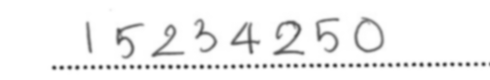

XIII - 1




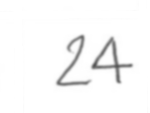

XVIII


In [14]:
for c in my_list:
  x,y,w,h = cv2.boundingRect(c)
  a = result[y -3 :y + h, x: x + w]
  b = pytesseract.image_to_string(a,config='--psm 6')
  b = b.lower()
  if "id" in b:
    if "student" in pytesseract.image_to_string(result[y - 5:y + h + 5, x - 150 : x + w]).lower():
      if "number" in pytesseract.image_to_string(result[y - 5:y + h + 5, x : x + w + 100]).lower():
        if t == 0:  
          ID = result[y - 25:y + h + 30, x + w + 100 : x + w + 450]
          cv2_imshow(ID)     
          print("XII")
          
      else:
        if t == 1: 
          ID = result[y -10 :y + h + 25, x + w : x + w + 500]
          cv2_imshow(ID)
          print("XIII")
        
        else:
          if t == 2:
            ID = result[y - 45:y + h + 5, x + w +10 : x + w + 500]
            cv2_imshow(ID)
            print("XIII - 1")

          else:
            if t == 4:
              ID = result[y - 45:y + h + 5, x + w  : x + w + 500]
              cv2_imshow(ID)
              print("XIII - 2")
          
            else:
              ID = result[y - 35:y + h + 20, x + w + 100: x + w + 500]
              cv2_imshow(ID)
              print("XIII - 3")
        
  else:
    if "number" in b:
      if "student" in pytesseract.image_to_string(result[y - 5:y + h + 5, x - 100 : x + w]).lower():
        if "id" not in pytesseract.image_to_string(result[y - 5:y + h + 5, x - 100 : x + w]).lower():
          ID = result[y - 20:y + h + 5, x + w : x + w + 400]
          cv2_imshow(ID)  
          print("XIV")

 
  if "total" in b:
    if "of" not in pytesseract.image_to_string(result[y - 5 :y + h, x: x + w + 100],config='--psm 6').lower():
      if "mark" in pytesseract.image_to_string(result[y - 5 :y + h, x: x + w + 100],config='--psm 6').lower():
        if t == 3:
          print("\n")
          TotalMarks = result[y - 125 :y-20, x: x + w + 120]
          cv2_imshow(TotalMarks)
          print("XV")
        
        else:
          if t == 0:
            print("\n")
            TotalMarks = result[y - 35:y + h+ 25, x + w  : x + w + 250]
            cv2_imshow(TotalMarks)
            print("XVI")

      if t == 1: 
        print("\n")
        TotalMarks = result[y :y + h+ 75, x+w: x + w +170]
        cv2_imshow(TotalMarks)
        print("XVII")

      if t == 2:
        print("\n")
        TotalMarks = result[y - 60 :y + h+20, x + w: x + w +150]
        cv2_imshow(TotalMarks)
        print("XVIII")
      
      if t == 4:
        print("\n")
        TotalMarks = result[y - 45 :y + h + 10, x + w: x + w +150]
        cv2_imshow(TotalMarks)
        print("XIX")

      if t == 5: 
        print("\n")
        TotalMarks = result[y - 35 :y + h, x + w: x + w +250]
        cv2_imshow(TotalMarks)
        print("XX")



================================ First Name ================================ 



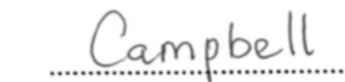

[INFO] loading handwriting OCR model...


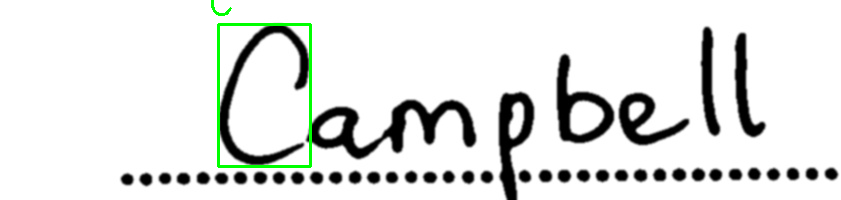

Outcome :C


In [17]:
if t == 0:   
  print('\n\n================================ Full Name ================================ \n')
  cv2_imshow(SurName)
  SSN = predict_letter(SurName).lower()

else:

  print('\n\n================================ First Name ================================ \n')
  cv2_imshow(FirstName)
  SFN = predict_letter(FirstName).lower()
  #except UnboundLocalError:
    #SFN = 'Not Defined'
    








================================ SurName ================================ 



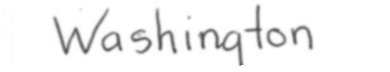

[INFO] loading handwriting OCR model...


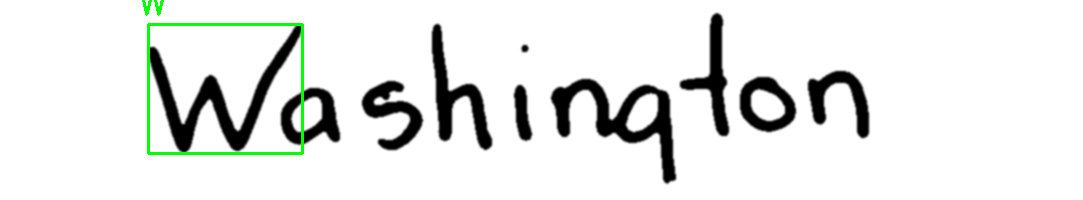

Outcome :W


In [ ]:

if t != 0:   
  print('\n\n================================ SurName ================================ \n')
  cv2_imshow(SurName)
  SSN = predict_letter(SurName).lower()




================================ ID ================================ 



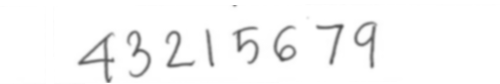

[INFO] loading handwriting OCR model...
[INFO] 4 - 100.00%
[INFO] 3 - 99.88%
[INFO] 2 - 100.00%
[INFO] 1 - 100.00%
[INFO] 5 - 100.00%
[INFO] 6 - 100.00%
[INFO] 7 - 100.00%
[INFO] 9 - 99.99%


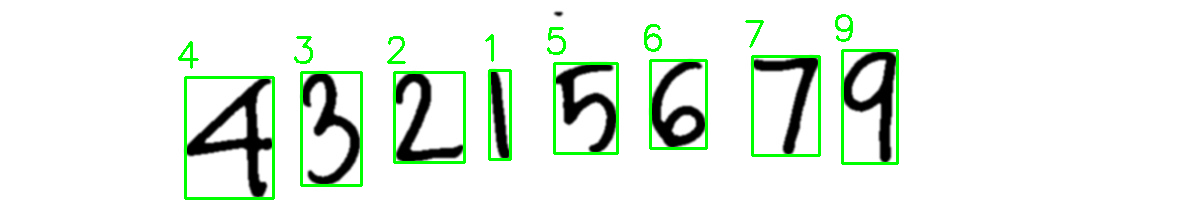

Outcome :43215679


================================= TotalMarks ================================ 



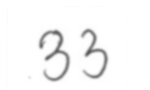

[INFO] loading handwriting OCR model...
[INFO] 3 - 100.00%
[INFO] 3 - 100.00%


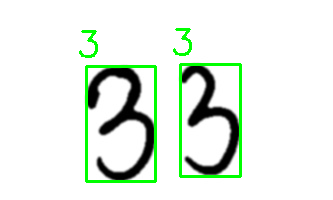

Outcome :33


In [ ]:
print('\n\n================================ ID ================================ \n')
cv2_imshow(ID)
if t == 5:
  SID = predict_digit(ID,0,0,30,0)
else:
  SID = predict_digit(ID,0,0,-40,0)

print('\n\n================================= TotalMarks ================================ \n')
cv2_imshow(TotalMarks)
STM = predict_digit(TotalMarks,0,0,0,0)


In [ ]:
def QM(v1,v2,v3,v4,v5,v6,v7,v8):
  Pred_TQM = 0
  for c in my_list:
    x,y,w,h = cv2.boundingRect(c)
    a = result[y - 3 :y + h, x: x + w]
    b = pytesseract.image_to_string(a,config='--psm 6')
    b = b.lower()
    if (("q1" in b) or ("ql" in b) or ("qi" in b) or
        ("q2" in b) or ("q3" in b) or ("q4" in b) or
        ("q5" in b) or ("qs" in b) or ("q6" in b) or
        ("q7" in b) or ("q8" in b) or ("q9" in b)):
      print(b)
      Mark = result[y + v1:y + h + v2, x + w + v3: x + w + v4]
      cv2_imshow(Mark)
      try:
        PQM = predict_digit(Mark,v5,v6,v7,v8)
      except ValueError:
        PQM = 0
      Pred_TQM = Pred_TQM + int(PQM)
  return Pred_TQM

q6



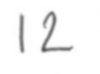

[INFO] loading handwriting OCR model...
[INFO] 1 - 100.00%
[INFO] 2 - 100.00%


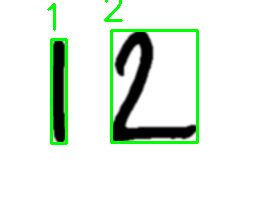

Outcome :12
q5



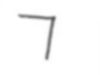

[INFO] loading handwriting OCR model...
[INFO] 7 - 100.00%


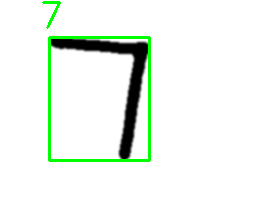

Outcome :7
q4



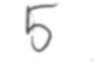

[INFO] loading handwriting OCR model...
[INFO] 5 - 100.00%


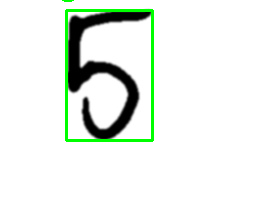

Outcome :5
q3



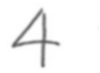

[INFO] loading handwriting OCR model...
[INFO] 4 - 100.00%


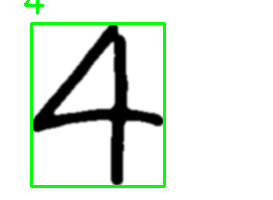

Outcome :4
q2



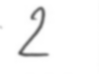

[INFO] loading handwriting OCR model...
[INFO] 7 - 81.71%


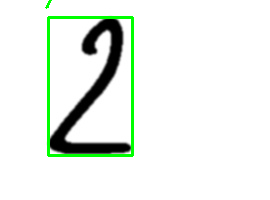

Outcome :7
qi



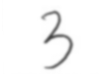

[INFO] loading handwriting OCR model...
[INFO] 3 - 99.99%


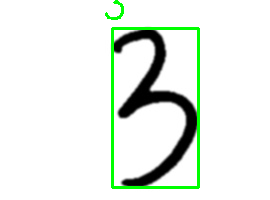

Outcome :3

 Total:  38


In [ ]:

Pred_TM= 0

if t != 3:
  if t== 0:
    Pred_TM = QM(0,40,40,200,0,0,-30,0)

  if t== 1:
    Pred_TM = QM(0,45,40,170,0,0,-30,0)

  if t == 2:
    Pred_TM = QM(-45,15,55,170,0,0,-30,0)

  if t == 4:
    Pred_TM = QM(-25,15,50,150,0,0,-30,0)

  if t == 5:
    Pred_TM = QM(0,30,60,150,0,0,-30,0)

print("\n Total: ", Pred_TM)


    



In [ ]:
  if t == 0:
    print("\nFirst Name: " + SSN)
  else:
    print("\nFirst Name: " + SFN)
    print("\nSurName: " + SSN)

  print("\nStudent ID: " + SID)
  print("\nTotal Marks: " + STM)


First Name: s

SurName: w

Student ID: 43215679

Total Marks: 33


In [ ]:
if t != 4:
  matching(SID,SFN,SSN)
else:
  matching(SID,'0',SSN) 

if str(Pred_TM) != STM:
  print(STM)
  print("Total mark need to be double checked")
else:
  print("Total Marks: " + STM)




ID : 43215679

FirstName:  george

LastName:  washington


33
Total mark need to be double checked
